In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
!nvidia-smi

Sun May 19 13:28:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    18W / 198W |    914MiB /  8116MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   39C    P8     7W / 198W |      2MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply,Dropout
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
import tensorflow as tf

import random

Using TensorFlow backend.


In [4]:
tf.__version__

'1.12.0'

In [5]:
from utils.utils import get_train, convert
from utils.preprocess import preprocess_sentence, preprocess_sentence_without_pad, max_length, tokenize

In [6]:
class LanguageIndex():
    def __init__(self, text_list):
        self.text_list = text_list
        self.char2idx = {}
        self.idx2char = {}
        self.vocab = set()
        self.create_index()
        self.max_len = self.get_max_len(text_list)
    
    def create_index(self):
        self.vocab = set((' '.join(self.text_list).split(' ')))
        self.vocab = sorted(self.vocab)
        self.vocab.insert(0, "<PAD>") # PADDING
        self.vocab.insert(1, "<UNK>") # PADDING

#         self.vocab.insert(1, "</s>") # PADDING

        self.char2idx = { ch:i for i,ch in enumerate(self.vocab) }
        self.idx2char = { i:ch for i,ch in enumerate(self.vocab) }
        
    def get_vocab_size(self):
        return len(self.vocab) + 2
    
    def create_char_seq(self, text):
        result = []
        for char in text.split(' '):
            if char in self.char2idx:
                result.append(self.char2idx[char])
            else:
                result.append(1)
        return result

    def get_max_len(self, text_list):
        return len(max(text_list, key=len))

In [7]:
df = get_train(nrows=5000)

In [8]:
df['firstSentence'] = np.vectorize(preprocess_sentence_without_pad)(df['firstSentence'])
df['secondSentence'] = np.vectorize(preprocess_sentence_without_pad)(df['secondSentence'])
df.head(10)

,firstSentence,secondSentence
0,"you ' re not alone , claire .","you are not alone , claire ."
1,"who told you to throw acid at vargas , hmm ?",who told you to throw acid at vargas ?
2,where the pure angel merges with the antic sphinx,where the pure angel merges with the antic sph...
3,where is it written what is it i ' m meant to be,where is it written what it is i ' m meant to be
4,we ' ll find the skipper and then we ' ll go h...,we ' ll find the skipper and then we go home .
5,seymour ' s darling is third . . . and little ...,seymour ' s darling is third . . . and little ...
6,"scud , do you read me ?","scud , you reading me ?"
7,jumby now wants to be born .,jumby want birth .
8,it was a difficult and long delivery .,the delivery was difficult and long .
9,"it ' s a shit , but it ' s better than nothing...","it ' s a shit , but it ' s better that nothing..."


In [9]:
#Preprocessing
input_text = df['firstSentence'].values
output_text = df['secondSentence'].values
input_language = LanguageIndex(input_text)
output_language = LanguageIndex(output_text)

input_maxlen = input_language.max_len
output_maxlen = output_language.max_len
vocab_size = input_language.get_vocab_size()
data_size = len(input_text)
output_vocab_size = output_language.get_vocab_size()

print('Max input length:', input_maxlen)
print('Max output length:', output_maxlen)

print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
data_size, vocab_size
output_vocab_size

Max input length: 85
Max output length: 98
There are 5000 lines and 2475 unique characters in your input data.


2503

In [10]:
m = data_size
Tx = input_maxlen
Ty = output_maxlen
X = [input_language.create_char_seq(line) for line in input_text]
Y = [output_language.create_char_seq(line) for line in output_text]

X = pad_sequences(X, maxlen=input_maxlen, padding='pre')
X = to_categorical(X, input_language.get_vocab_size())
X = X.reshape(data_size, input_maxlen, vocab_size)

Y = pad_sequences(Y, maxlen=output_maxlen, padding='post')
Y = to_categorical(Y, output_language.get_vocab_size())
Y = Y.reshape(data_size, output_maxlen, output_vocab_size)

print(X.shape, Y.shape)

(5000, 85, 2475) (5000, 98, 2503)


In [11]:
from keras.activations import softmax
from keras.layers import Lambda
from keras import backend as K
K.clear_session()

def softMaxAxis1(x):
    return softmax(x,axis=1)


In [12]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template.  

#These are global variables (shared layers)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(output_language.max_len, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)


In [13]:
def one_step_attention(a, s_prev):
    #Fill code here
    split_length = lambda x: x.shape[2]//2
    key = Lambda(lambda x: x[:,:,:split_length(x)])(a)
    value = Lambda(lambda x: x[:,:,split_length(x):])(a)

    
    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    concat = concatenator([key, s_prev])
    # attention function
    e = fattn_1(concat)
    energies = fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)

    #calculate a context vector
    context = dotor([attention_scores, value])

    return context

In [14]:
#FILL CODE HERE
n_h = 64 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell

dence_1 = Dense(128, activation="relu")
drop_out_1 = Dropout(0.5)
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [15]:
n_h

64

In [16]:
#FIT YOUR MODEL HERE
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(m, Tx, n_h*2))(X)
  
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
        
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [17]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 85, 2475)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 85, 128)      1300480     input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 85, 64)       0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
repeat_vec

In [19]:
opt = Adam(lr= 0.01, decay = 0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0, 1))

In [18]:

model.fit([X, s0, c0], outputs, epochs=20, batch_size=64)
# model.fit([X, s0, c0], outputs, epochs=60, batch_size=120)

Epoch 1/20
5000/5000 [==============================] - 143s 29ms/step - loss: 67.6457 - dense_4_loss: 0.3446 - dense_4_acc: 0.1030 - dense_4_acc_1: 0.0282 - dense_4_acc_2: 0.0544 - dense_4_acc_3: 0.1356 - dense_4_acc_4: 0.4062 - dense_4_acc_5: 0.6514 - dense_4_acc_6: 0.8074 - dense_4_acc_7: 0.9006 - dense_4_acc_8: 0.9428 - dense_4_acc_9: 0.9640 - dense_4_acc_10: 0.9730 - dense_4_acc_11: 0.9790 - dense_4_acc_12: 0.9822 - dense_4_acc_13: 0.9836 - dense_4_acc_14: 0.9846 - dense_4_acc_15: 0.9852 - dense_4_acc_16: 0.9860 - dense_4_acc_17: 0.9864 - dense_4_acc_18: 0.9870 - dense_4_acc_19: 0.9872 - dense_4_acc_20: 0.9872 - dense_4_acc_21: 0.9872 - dense_4_acc_22: 0.9872 - dense_4_acc_23: 0.9872 - dense_4_acc_24: 0.9872 - dense_4_acc_25: 0.9872 - dense_4_acc_26: 0.9872 - dense_4_acc_27: 0.9872 - dense_4_acc_28: 0.9872 - dense_4_acc_29: 0.9872 - dense_4_acc_30: 0.9872 - dense_4_acc_31: 0.9872 - dense_4_acc_32: 0.9872 - dense_4_acc_33: 0.9872 - dense_4_acc_34: 0.9872 - dense_4_acc_35: 0.9872 - 

In [20]:
#task 4
#fill your code here
def create_input_seq(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line.split(' '):
            if char in input_language.char2idx:
                temp.append(input_language.char2idx[char])
        X.append(temp)
    X = pad_sequences(X, maxlen=input_language.max_len)
    return X

def prep_input(input_list):
    X = create_input_seq(input_list)
    X = to_categorical(X, vocab_size)
    X = X.reshape(len(input_list), input_language.max_len, vocab_size)
    return X

def print_prediction(prediction):
    prediction = np.swapaxes(prediction, 0, 1)
    prediction = np.argmax(prediction, axis = -1)
    
    for j in range(len(prediction)):
        output = " ".join([output_language.idx2char[int(i)] for i in prediction[j]])
        output = output.replace('<PAD> ', '')
        print(output)

print(input_text[3])
EXAMPLES = [input_text[3]]
EXAMPLES = prep_input(EXAMPLES)
prediction = model.predict([EXAMPLES , s0, c0])
print_prediction(prediction)

where is it written what is it i ' m meant to be
wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong


In [21]:
if not os.path.exists('../models/'): os.makedirs('../models/')

In [157]:
model.save_weights('../models/seq2seq-keyvalue-attention.h5')

In [22]:
model.load_weights('../models/seq2seq-keyvalue-attention.h5')

In [23]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['font.family']='Loma' #you can change to other font that works for you
plt.rcParams['font.family'] = 'TH Sarabun New'

#fill your code here
def attention_observer(text):
    input_texts = [text]
    input_text_seq = create_input_seq(input_texts)
    input_texts = prep_input(input_texts)
    attention_map = np.zeros((Ty, Tx))
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.get_layer('attention_scores')
    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([input_texts, s0, c0])
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]
    prediction = model.predict([input_texts, s0, c0])
    prediction = np.swapaxes(prediction, 0, 1)
    prediction = np.argmax(prediction, axis = -1)
    for j in range(len(prediction)):
        predicted_text = [output_language.idx2char[int(i)] for i in prediction[j]]
    output_length = Ty
    input_text_list = [[input_language.idx2char[int(i)] for i in input_text_seq[j]] for j in range(len(input_text_seq))]
    input_text_list = input_text_list[0]
    input_length = len(input_text_list)
    return input_text_list, attention_map, predicted_text

In [24]:
text = input_text[2]
input_text_list, attention_map, predicted_text = attention_observer(text)

In [25]:
len(input_text_list) - 1 - input_text_list[::-1].index('<PAD>')

75

In [26]:
predicted_text.index('<PAD>')

10

<Figure size 432x288 with 0 Axes>

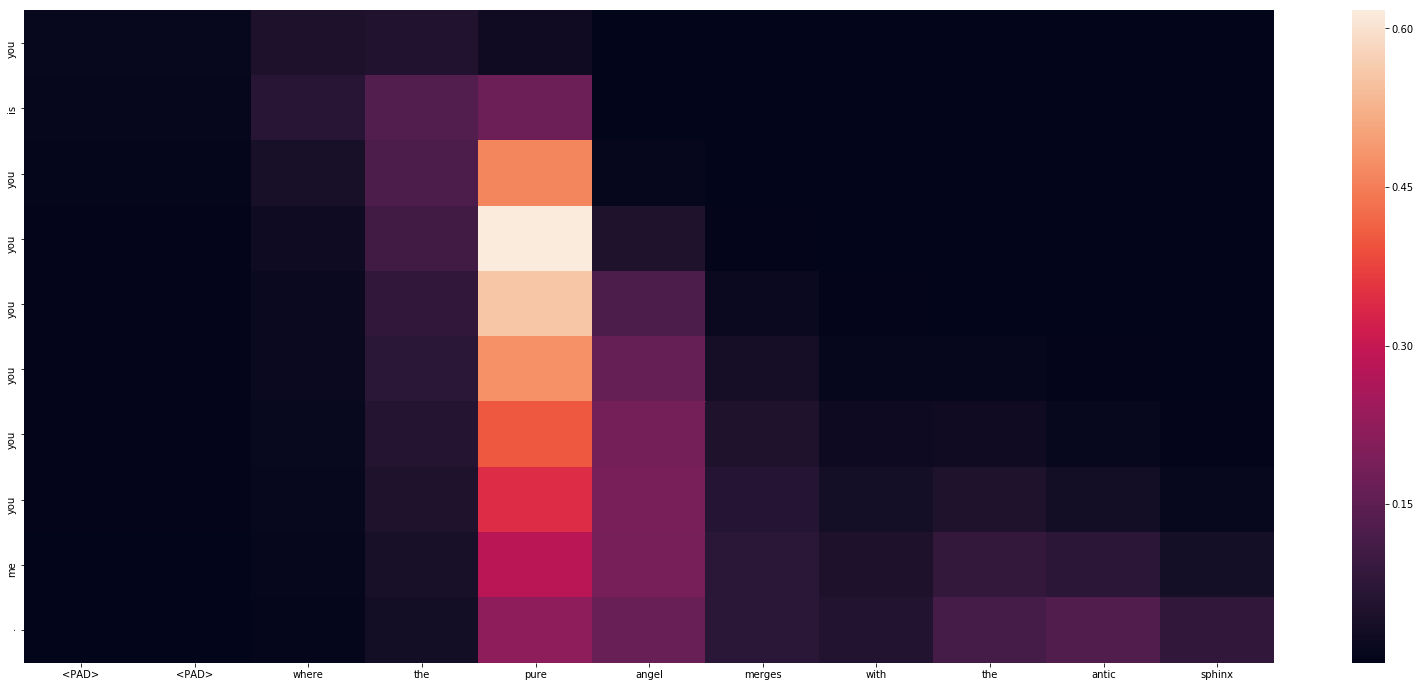

In [29]:
plt.clf()
plt.figure(figsize=(28,12))
ax = sns.heatmap(attention_map[:10, 74:len(input_text_list) + 2],
    xticklabels=[w for w in input_text_list[74:]],
    yticklabels=[w for w in predicted_text[:10]])
plt.savefig('aaa.jpg')

In [30]:
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
def test_blue(expected, candidate):
    candidate = candidate.split(' ')
    candidate = candidate[:candidate.index('<PAD>')]
    expected = expected.split(' ')
    reference = [expected]
    smoothie = SmoothingFunction().method4
    return bleu([expected], candidate, smoothing_function=smoothie)

In [31]:
df_test = get_train(nrows=5000)
df_test['firstSentence'] = np.vectorize(preprocess_sentence_without_pad)(df_test['firstSentence'])
df_test['secondSentence'] = np.vectorize(preprocess_sentence_without_pad)(df_test['secondSentence'])
test_input_text = df_test['firstSentence'].values[4900:]
test_output_text = df_test['secondSentence'].values[4900:]

In [33]:
 blues = []
for i in range(10):
    EXAMPLES = [test_input_text[i]]
    EXAMPLES = prep_input(EXAMPLES)
    prediction = model.predict([EXAMPLES , s0, c0])
    prediction = np.swapaxes(prediction, 0, 1)
    prediction = np.argmax(prediction, axis = -1)
    for j in range(len(prediction)):
        output = " ".join([output_language.idx2char[int(k)] for k in prediction[j]])
    bb = test_blue(test_output_text[i], output)
    blues.append(bb)
#     if bb > 0.28:
#     print(i)
    text = test_input_text[i]
    input_text_list, attention_map, predicted_text = attention_observer(text)
    print(text)
    print(output)
    print(test_output_text[i])
    plt.clf()
    plt.figure(figsize=(28,12))
    fa = len(input_text_list) - 1 - input_text_list[::-1].index('<PAD>')
    fb = predicted_text.index('<PAD>')
    print(fa, fb)
    ax = sns.heatmap(attention_map[:fb, fa:len(input_text_list) + 2],
        xticklabels=[w for w in input_text_list[fa:]],
        yticklabels=[w for w in predicted_text[:fb]])
#         plt.cl
    plt.savefig('out_pic_keyvalue/' + str(i) + '.jpg')
    plt.clf()
#     break
# np.average(blues)
# blues

you wanted to speak with me ?
you is you you you me ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
you wanted to talk to me ?
77 7


/home/ubuntu/conda/envs/py3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['TH Sarabun New'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


20 years .
the . . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
twenty years .
81 3
i ' m jealous .
i ' . . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

<Figure size 432x288 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

<Figure size 2016x864 with 0 Axes>

In [167]:
np.average(blues) * 100

21.249410024390187

In [120]:
np.max(blues) * 100

28.66227639866161

In [121]:
np.min(blues) * 100

0.0

In [ ]:
print(input_text[3])
EXAMPLES = [input_text[3]]
EXAMPLES = prep_input(EXAMPLES)
prediction = model.predict([EXAMPLES , s0, c0])
print_prediction(prediction)

In [48]:
from nltk.translate.bleu_score import corpus_bleu
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test'], ['ss', 'aaa']]
score = corpus_bleu(references, candidates)
print(score)

AssertionError: The number of hypotheses and their reference(s) should be the same 

In [52]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000


In [89]:
reference = 'this is a test'
candidate = 'this is <PAD>'
print('Individual 1-gram: %f' % test_blue(reference, candidate))

[['this', 'is', 'a', 'test']]
['this', 'is']
Individual 1-gram: 0.000000


/home/ubuntu/conda/envs/py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/conda/envs/py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [92]:
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction

In [169]:
def demo(text):
    EXAMPLES = prep_input([text])
    prediction = model.predict([EXAMPLES , s0, c0])
    print_prediction(prediction)

In [170]:
print("You'll never walk alone")
demo("You'll never walk alone")

You'll never walk alone
you , the . . <PAD>
